# Hodgkin Huxeley sandbox

The aim to learn is to make HH models with many neurons.
These are to be parametrised with different current desities.
Once setup such a model can be used to probe corellated channel expression.

First I want to be familiar with brian enough to do the following tasks:

1. Generate HH models with parametrised neurons
2. Run simulations with them that are similar to lab ephys settings (CC steps, VC steps, I/O curves)

After accomplishing this:

1. Research sane input parameters/model equations for a simple neuron with ~3-4 conductances (see Balachandar)
2. Create a neuron model and parametrise it with bivariate, correlated current densities
3. Run simulations and prepare scripts that deal with the output

Such scripts will essentially do the same task as the scripts I would need to analyse real data, so we are killing two birds with one stone here.


In [2]:
# Setup the environment
# Import brian
from brian2 import *
# data frame support and `tidy` plotting
import pandas as pd
import numpy as np
import seaborn as sns

# Assign some tidier functions for the outputs generated by brian.
def tidy_spike(s_mon_object) :
    """
    This function takes all the data from within a spikemonitor brian object
    and makes it into a tidy pandas frame
    """
    # extract the data to a wide frame
    sdata_wide =  pd.DataFrame.from_dict(s_mon_object.all_values()['t'],orient = 'index')
    sdata_wide.index.name = 'neuron'
    sdata_wide.reset_index(inplace=True)
    # there will be now 1 neuron column with number of neuron rows
    # and a column for each spike (as many columns as the maximum number of spikes for a neuron)
    # there is an index column and a neuron column, so the max number of spikes
    # and the number of data colums is the number of columns -2
    spike_max = sdata_wide.shape[1]
    
    # pivot longer by neuron
    sdata_long = sdata_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,spike_max-1)),
                               var_name = 'spikeno',
                               value_name = 't')
    
    # tidy and update the thing
    sdata_long = sdata_long.sort_values(['neuron', 'spikeno'])
    # drop NA values
    sdata_long = sdata_long.dropna()
    # add a proper numeric time variable
    sdata_long['t_ms'] = sdata_long['t'].apply(lambda x: x/ms)
    
    #return the thing
    return(sdata_long)
    
# Make a tidier for by neuron summaries
def tidy_byN(aneuron, monitorobj):
    """
    This function takes a brian neuron group
    and a spike monitor object of it
    then returns a tidy pandas frame of the start and and values and the firing rates
    """
    # extracts all the model starting parameters and the last timepoint
    byN = aneuron.get_states(units=False, format='pandas')
    
    # duration of the run
    run_dur = byN['t_in_timesteps'][0]*byN['dt'][0]
    # now we can assign the firing rate data as new columns
    byN['nAP'] = pd.Series(np.array(monitorobj.count))
    # calculate firing rate
    byN = byN.assign(FRate_hz = byN['nAP']/run_dur)
    return(byN)

def tidy_v(ts_statemon):
    '''
    Function that will return a tidy timeseries dataframe
    from a brian StateMonitor object containing timeseries.
    '''
    # start over with a wide frame
    ts_frame = pd.DataFrame(ts_statemon.v)
    
    # the number of rows is the number of neurons
    n_neuron = ts_statemon.v.shape[0]
    
    # make long with 1 Neuron as 1 column
    ts_frame = ts_frame.transpose()
    # add the time axis
    ts_frame.index.name = 't_dummy'
    ts_frame['t'] = pd.Series(np.array(ts_statemon.t))
    # this does the job
    return(pd.melt(ts_frame,
                   value_vars = list(range(0, n_neuron)),
                   id_vars = ['t'],
                   var_name = "neuron",
                   value_name = 'v'))

# Current Clamp experiment with a parametrised neuron group
First Task: Run a current clamp experiment and show the result.
The following HH model is taken from the examples in the brian [introduction](https://brian2.readthedocs.io/en/stable/resources/tutorials/3-intro-to-brian-simulations.html).


In [112]:
# Parameters
area = 20000*umetre**2              # Membrane area
Cm = 1*ufarad*cm**-2 * area         # capacitance per area
gl = 5e-5*siemens*cm**-2 * area     # leak conductance per area
El = -65*mV                         # leak reversal (RMP)
EK = -90*mV                         # potassium reversal
ENa = 50*mV                         # sodium reversal
g_na = 100*msiemens*cm**-2 * area   # Na conductance per area
g_kd = 30*msiemens*cm**-2 * area    # K conductance per area 
VT = -63*mV                         # nernst slope
N = 3                               # Numer of neurons in the group
I_stim = linspace(0, 0.1, 4)*namp
eqs_HH_3 = '''
# Voltage equation
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
# Na activation particle
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
# K activation particle
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
# Na inactivation particle
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1

I : amp (shared) # This is necessary so each neuron has the same current injection
C : farad
'''
# Create the neuron group
# In this example everything is kept constant, but there is 3 neurons with different capacitance
group = NeuronGroup(N, eqs_HH_3,
                    #threshold='v > -40*mV',
                    #refractory='v > -40*mV',
                    method='exponential_euler')

# Start the simulation at resting potential
group.v = El
group.I = 0*namp # start with no stimulation
#assign the capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)

# store the initial state of the simulation
groupnet = Network(group,statemon)
groupnet.store()

In [113]:
start_scope()
# Run the simulation
# make an empty list for the results
capresult = []
# time for each sweep (ms)
runtime = 50
for I in I_stim:
    # restore the system
    groupnet.restore()
    # set the new stimulation current
    group.I = I
    groupnet.run(runtime*ms)
    runresult = tidy_v(statemon)
    # write the stimulation current and time by sweep
    runresult['sweep'] = [I/namp] * len(runresult['v'])
    rowperneuron = int(len(runresult['v'])/N) # this needs to an integer
    runresult['t_stim'] = tile(np.linspace(0,runtime, rowperneuron), N) # need to add n neurons here
    capresult.append(runresult)

WARNING    "I" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 33.33333333 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "I" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 66.66666667 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "I" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 100. * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [114]:
#tidy and plot
capresult = pd.concat(capresult)

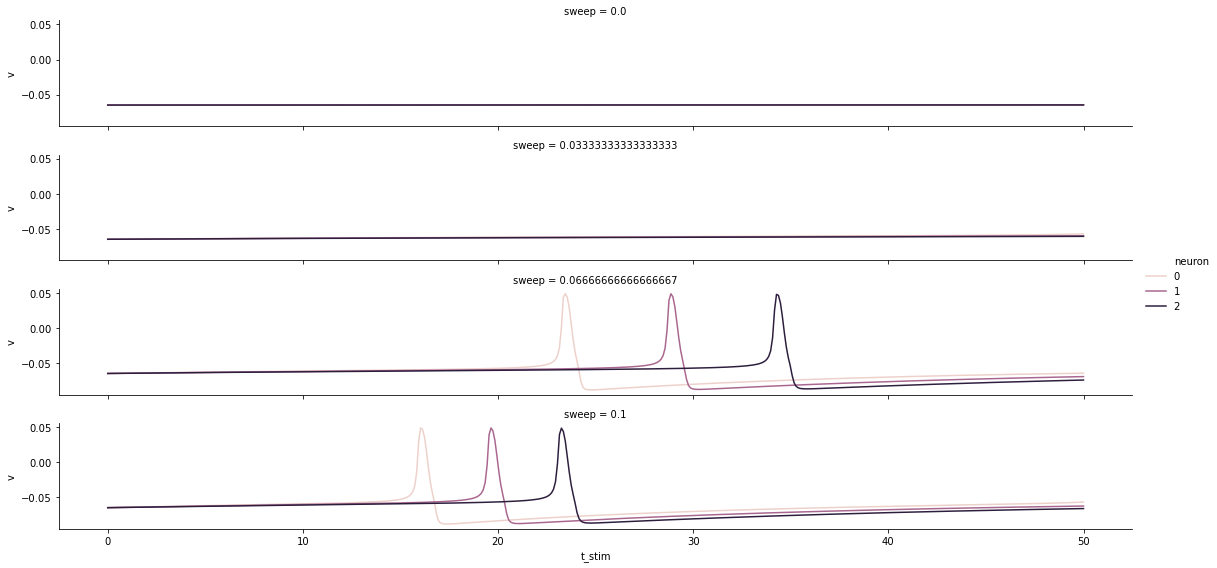

In [139]:
sns.relplot(x = 't_stim',
            y = 'v',
            kind = 'line',
            #hue = 'sweep',
            row = 'sweep',
            height = 2,
            aspect = 8,
            #row = 'neuron',
            hue = 'neuron',
            data = capresult)

I played with the stimulation voltage, it seems like spikes mostly go to full 50 mV amplitude with the given conductances even for small injections.

That is encouraging, the output is tidy, now we can try to include the per-neuron parameters, to summarise more.

We can do this with a spikemonitor object.

In [141]:
start_scope()
# re-assign the group
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > 45*mV', # Set this to a high value, I like the spiketime to be more with the peak!
                    refractory='v > 0*mV',
                    method='exponential_euler')

# Start the simulation at resting potential
group.v = El
group.I = 0*namp # start with no stimulation
#assign the capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')

# store the initial state of the simulation
groupnet = Network(group,statemon, spikemon)
groupnet.store()

# Run the simulation now instead tidy the per neuron sumamry
# make an empty list for the results

# renew the I iterator so we can manipulate it closer to where it takes effect
I_stim = linspace(0, 4, 4)*namp

tsresult = []       # container for the timeseries result
summaryresult = []  # container for the per-neuron summaries
# time for each sweep (ms)
runtime = 50
for I in I_stim:
    # restore the system
    groupnet.restore()
    # set the new stimulation current and run
    group.I = I
    groupnet.run(runtime*ms)
      
    # tidy and save the time series results
    runresult = tidy_v(statemon)
    runresult['sweep'] = [I/namp] * len(runresult['v'])
    rowperneuron = int(len(runresult['v'])/N) # this needs to an integer
    runresult['t_stim'] = tile(np.linspace(0,runtime, rowperneuron), N) # need to add n neurons here
    tsresult.append(runresult)
    
    # tidy and save the summary results
    runsummary = tidy_byN(group, spikemon)
    summaryresult.append(runsummary)
    

In [142]:
#tidy and plot
tsresult = pd.concat(tsresult)
summaryresult = pd.concat(summaryresult)

This plot will show the firing rate dependent on capacitance for every stimulation.

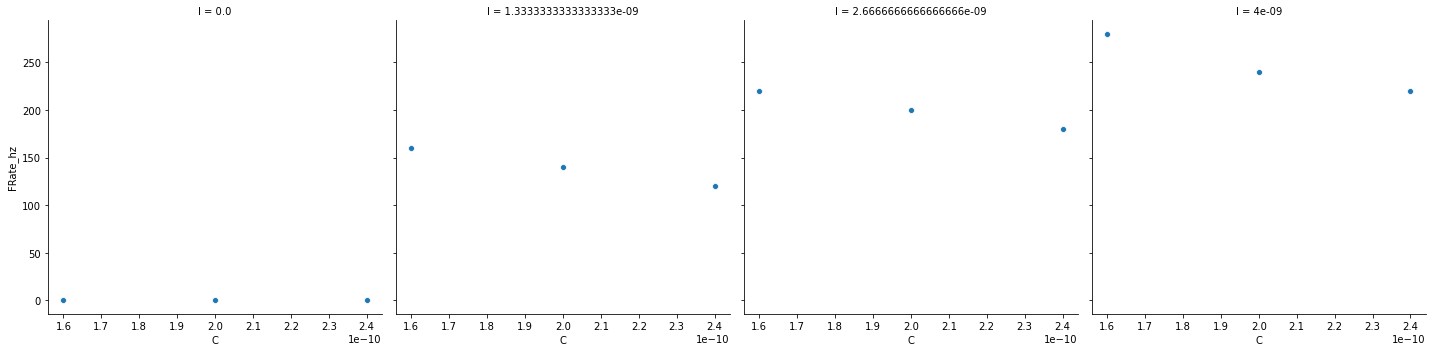

In [143]:
sns.relplot(data = summaryresult,
           x = "C",
           y = "FRate_hz",
           col = "I")

Next one will show the timecourses.

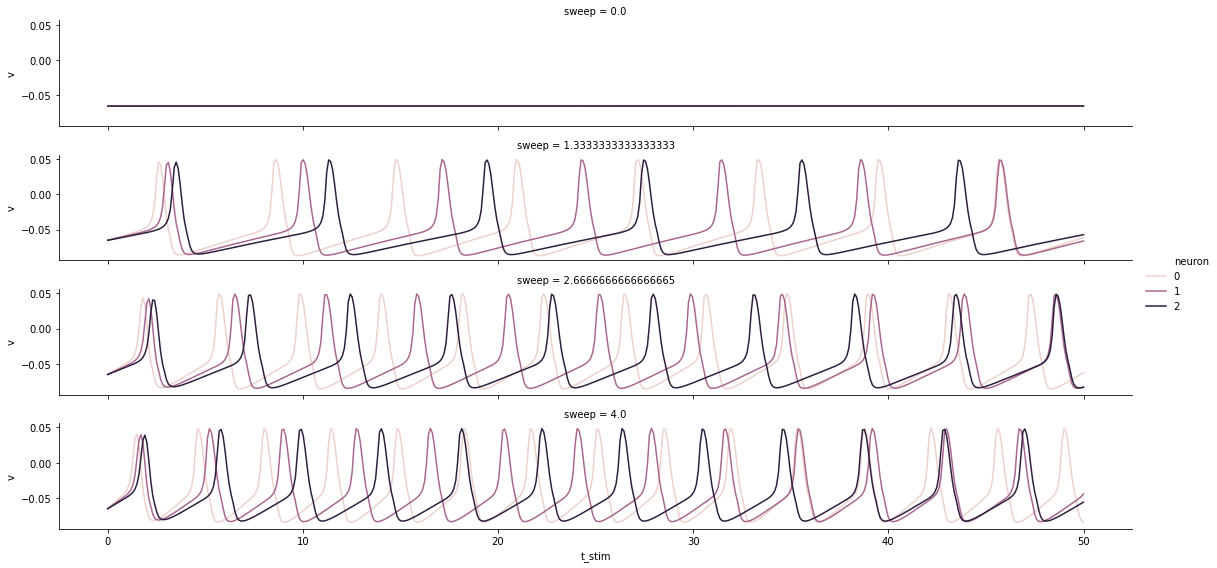

In [146]:
sns.relplot(x = 't_stim',
            y = 'v',
            kind = 'line',
            #hue = 'sweep',
            row = 'sweep',
            height = 2,
            aspect = 8,
            #row = 'neuron',
            hue = 'neuron',
            data = tsresult)

Next, make it more complex and sample a larger range of C to get a more continous response curve.
To do this we vary C systematically in 100 neurons.

In [230]:
start_scope()
# re-assign the group
N = 100
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')

# Start the simulation at resting potential
group.v = El
group.I = 0*namp # start with no stimulation
# assign the capacitances
group.C = np.linspace(0.2,1.5,N)*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')

# store the initial state of the simulation
groupnet = Network(group,statemon, spikemon)
groupnet.store()

In [231]:
# rerassing the stimulus protocol so its easier to manipulate
I_stim = linspace(0.1, 20, 20)*namp

tsresult = []       # container for the timeseries result
summaryresult = []  # container for the per-neuron summaries
# time for each sweep (ms)
runtime = 300
for I in I_stim:
    # restore the system
    groupnet.restore()
    # set the new stimulation current and run
    group.I = I
    groupnet.run(runtime*ms)
      
    # tidy and save the time series results
    #runresult = tidy_v(statemon)
    #runresult['sweep'] = [I/namp] * len(runresult['v'])
    #rowperneuron = int(len(runresult['v'])/N) # this needs to an integer
    #runresult['t_stim'] = tile(np.linspace(0,runtime, rowperneuron), N) # need to add n neurons here
    #tsresult.append(runresult)
    
    # tidy and save the summary results
    runsummary = tidy_byN(group, spikemon)
    summaryresult.append(runsummary)

I commented out the timeseries objects because in all likelyhood they would grow quite large.
Now plot the continous response to capacitance.

In [232]:
#tsresult = pd.concat(tsresult)

summaryresult = pd.concat(summaryresult)
summaryresult['I'] = summaryresult['I']/1e-9

The following shows the result of the current clamp experiment.
Full response curves of capacitance and firing rate for different stimulation voltages.

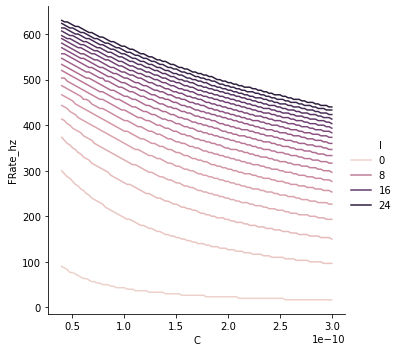

In [200]:
sns.relplot(data = summaryresult,
           x = "C",
           y = "FRate_hz",
           kind = 'line',
           #palette="pastel",
           hue = "I")

# Voltage clamp experiment
Without using particularly different paradigms in terms of the coding we can run voltage clamp experiments.
Actually, there is no current equation in the model, so we need to add it.

The model contained a line for the membrane potential V:
\begin{equation}
\frac{\partial V}{\partial t} = \frac{g_l(E_l - V) - g_{\text{Na}} m^3 h (V - E_{\text{Na}}) - g_{\text{K}} n^4 (V-E_{\text{K}}) + I}{C}
\end{equation}
$I$ in this case being a injected stimulation current.

This is sctually just describing the effect of the time course of the membrane currents on $V$.
Everything in the counter of the fraction is defining the currents.

The above says nothing more than that $V$ depends on the sum of ionic currents divided by capacitance that needs to be charged to change it:
\begin{equation}
\frac{\partial V}{\partial t} = \frac{\sum{} I_{\text{channel}}}{C}
\end{equation}

Therefore, we can just take the membrane current, also split by channel if needed into our equation system.
This is basically just Ohms law, all the time dependence lies in the equations for the gating particles.
\begin{equation}
I_m = g_l(E_l - V) - g_{\text{Na}} m^3 h (V - E_{\text{Na}}) - g_{\text{K}} n^4 (V-E_{\text{K}})
\end{equation}
Individual channel example, here sodium:

\begin{equation}
\frac{\partial I_{\text{Na}}}{\partial t} = g_{\text{Na}} m^3 h (V - E_{\text{Na}})
\end{equation}

For now we can introduce the equation above for $I_m$ and modify the voltage equation to

\begin{equation}
\frac{\partial V}{\partial t} = \frac{I_m + I}{C}
\end{equation}

In [273]:
start_scope()
# re-assign the group
N = 1
# before this was -65..
El = 0*mV
eqs_HH_new = '''
# Current injected
I : amp (shared) # This is necessary so each neuron has the same current injection
# Capacitance of the membrane
C : farad
# Voltage clamp
v : volt

# Membrane current
Im = gl*(v-El) + g_na*(m*m*m)*h*(v-ENa) + g_kd*(n*n*n*n)*(v-EK): amp

# Voltage equation
#dv/dt = (Im + I)/C : volt

# Channel gating
# Na activation particle
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
# K activation particle
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
# Na inactivation particle
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1

'''
group = NeuronGroup(N, eqs_HH_new,
                    #threshold='v > -40*mV',
                    #refractory='v > -40*mV',
                    method='exponential_euler')

# Start the simulation at resting potential
group.v = -65*mV
group.I = 0*namp # start with no stimulation
# assign the capacitances
group.C = np.linspace(0.2,1.5,N)*ufarad*cm**-2*area
statemon = StateMonitor(group, 'Im', record=True)

# store the initial state of the simulation
# do not add the statemonitor, as before. It will just record the equilibration step.
# that will then mess up the registering
groupnet = Network(group, statemon)

# run the simulation at RMP for a bit to equilibrate
groupnet.run(100*ms)
groupnet.store()

In [274]:
# We need a new tidier function to get `I` from statemonitors
# Since getting the data is a method
# And I did not find a way to use wildcard methods
# We need a new tidier for every variable we might record with the monitor...

def tidy_I(ts_statemon):
    '''
    Function that will return a tidy timeseries dataframe
    from a brian StateMonitor object containing I timeseries.
    '''
    # start over with a wide frame
    ts_frame = pd.DataFrame(ts_statemon.Im)
    
    # the number of rows is the number of neurons
    n_neuron = ts_statemon.Im.shape[0]
    
    # make long with 1 Neuron as 1 column
    ts_frame = ts_frame.transpose()
    # add the time axis
    ts_frame.index.name = 't_dummy'
    ts_frame['t'] = pd.Series(np.array(ts_statemon.t))
    # this does the job
    return(pd.melt(ts_frame,
                   value_vars = list(range(0, n_neuron)),
                   id_vars = ['t'],
                   var_name = "neuron",
                   value_name = 'Im'))

In [275]:
# re- assign the "stimulus protocol" so its easier to manipulate
V_stim = linspace(-80, 50, 20)*mV

tsresult = []       # container for the timeseries result
summaryresult = []  # container for the per-neuron summaries
# time for each sweep (ms)
runtime = 20
for V in V_stim:
    # restore the neurons 
    groupnet.restore()
    # set the new stimulation current and run
    group.v = V
    # run the neuron with monitor
    groupnet.run(runtime*ms)
      
    # tidy and save the time series results
    runresult = tidy_I(statemon)
    runresult['sweep'] = [V/mV] * len(runresult['Im'])
    rowperneuron = int(len(runresult['Im'])/N) # this needs to an integer
    runresult['t_stim'] = tile(np.linspace(0,runtime +100, rowperneuron), N) # need to add n neurons here
    tsresult.append(runresult)
    
    # tidy and save the summary results
    #runsummary = tidy_byN(group, spikemon)
    #summaryresult.append(runsummary)

In [276]:
tsresult = pd.concat(tsresult)

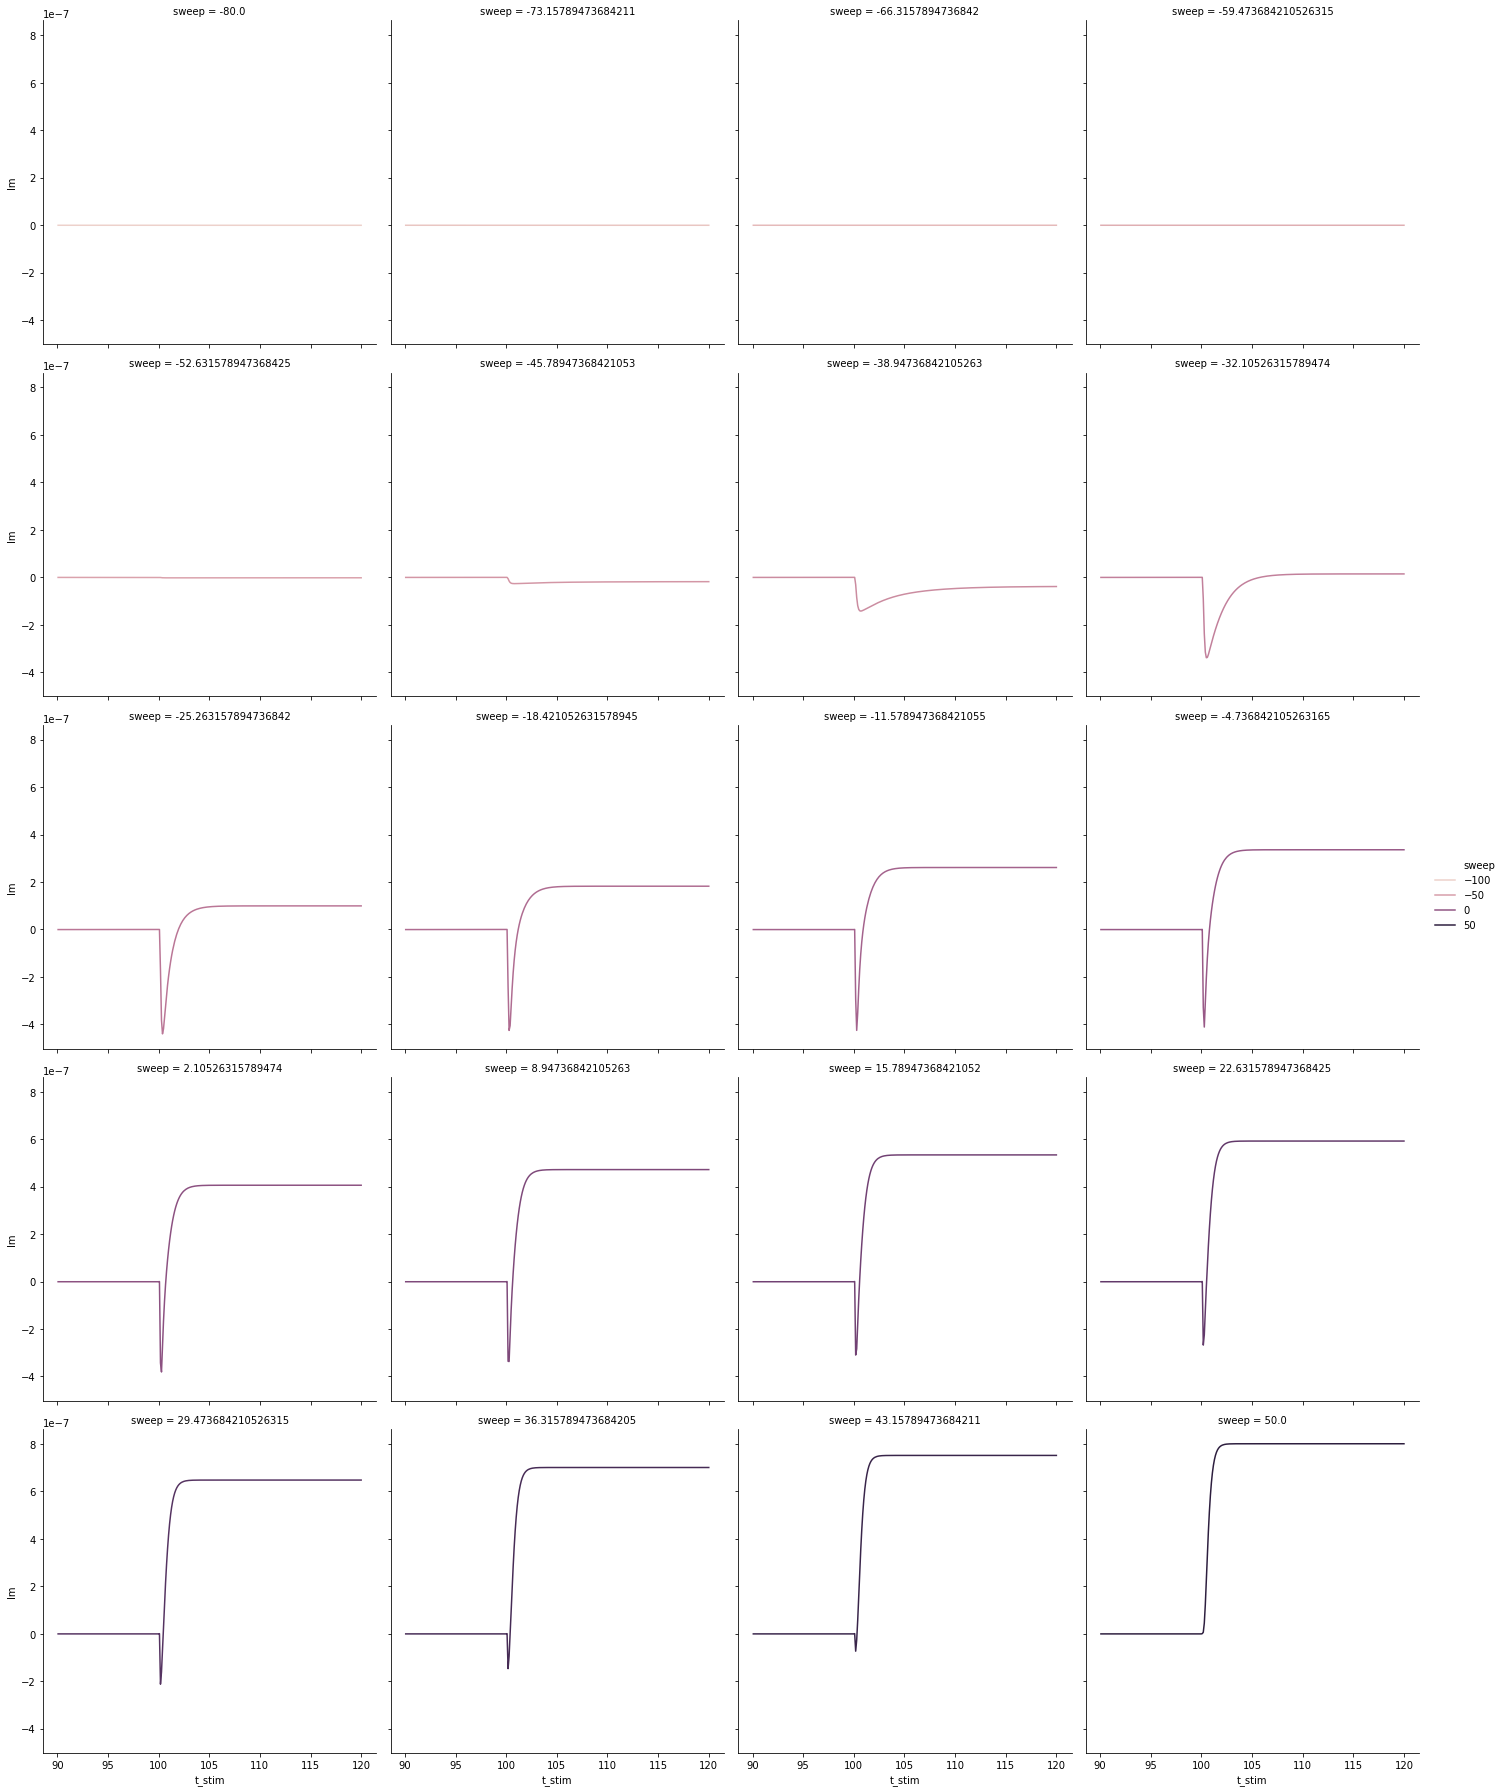

In [277]:
sns.relplot(data = tsresult.query('t_stim > 90'),
            x = 't_stim',
            y = 'Im',
            hue = 'sweep',
            col = 'sweep',
            col_wrap = 4,
            kind = 'line',
           facet_kws={'sharey':True, 'sharex': True})